<a href="https://colab.research.google.com/github/Tim-Lukas-H/DS500_data_science_project/blob/master/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3

The goal of this assignment is to practice designing, debugging and training of convolutional neural networks using PyTorch for classifying 200 bird species in Caltech-UCSD Birds 200-2011 image dataset. We will also learn to use the transfer learning approach to exploit pertained deep networks and prevent overfitting in the absence of large training datasets.


As always, we first import PyTorch libraries.

In [2]:
import torch, os, pathlib
#from matplotlib import pyplot as plt
from torch import nn, optim
from torch.nn.functional import max_pool2d
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.cuda.amp import autocast, GradScaler
#from torch.optim.lr_scheduler import StepLR
from functools import partial
torch.manual_seed(123)
torch.use_deterministic_algorithms(False)

Again, as in previous tutorials, next we need to mount Google Drive in Colab. This will allow us to access dataset files stored on our Google Drive.
Run the next cell to start the Google Drive mount process.
Click on the link that the running the Colab cell prints.
You’ll be prompted to sign into your Google account and a message about the permissions that this action will grant to Colab.
After accepting, you’ll be shown a one-time code. Copy and paste the code back into the Colab cell and hit enter. Now the Colab notebook has mounted your Google Drive.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Part A - Convolutional Neural Network Classifier

In the first part, you will implement the following convolutional neural network baseline for the 200 category classification task.


### 1. 
Implement VGG block in PyTorch and use the block to implement VGG-11, VGG-13 and VGG-16 networks corresponding to configuration A, B and D in the table below. Note that every convolutional layer is followed by a ReLU activation.
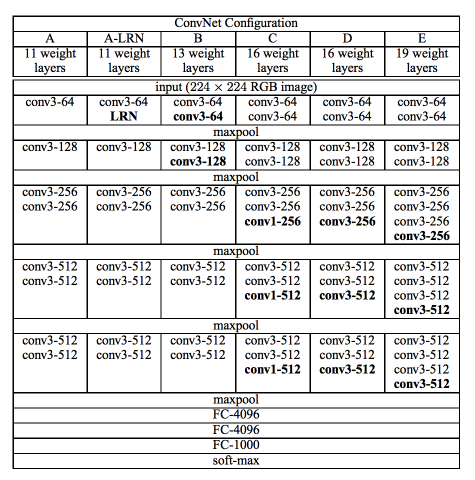

In [4]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding = (self.kernel_size[0] // 2, self.kernel_size[1] // 2)


conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=True)

def vgg(spec):
    layers = []
    in_channels = 3
    conv_arch = dict({
        11: [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        13: [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
        16: [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
    })
    for v in conv_arch[spec]:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            layers += [conv3x3(in_channels, v), nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(
        *layers, nn.Flatten(),
        # The fully-connected part
        nn.Linear(in_channels * 7 * 7, 4096),
        nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(),
        nn.Linear(4096, 200), nn.Softmax(dim=1))


### 2. 
Download the Caltech-UCSD Birds 200-2011 from this [link](https://drive.google.com/file/d/1M2td6Iz6Ty3GvUfAsYQWG4vODVjJ5HSo/view?usp=sharing). The dataset is already split into training and testing datasets. Upload the dataset to your Google Drive. Split the training dataset into training and validation dataset containing 90% and 10% of the examples respectively. 


In [ ]:
data_path = pathlib.PurePath('/content/drive/MyDrive/DS405B/datasets/cub/')

train_path, test_path = [os.path.join(data_path, x) for x in ["train", "test"]]

c_data = ImageFolder(
    root=train_path,
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]))

c_data_sub = torch.utils.data.Subset(c_data, range(1, 500))
c_data = torch.stack([img_t for img_t, _ in c_data_sub], dim=3).view(3, -1)

c_mean, c_std = c_data.mean(dim=1), c_data.std(dim=1)

In [ ]:
train_val_data = ImageFolder(
    root=train_path,
    transform=transforms.Compose([
        transforms.RandomResizedCrop([224, 224]),
        transforms.Normalize(c_mean, c_std),
        transforms.ToTensor()
    ]))

train_data, val_data = random_split(
    train_val_data,
    (lambda x: [int(x*0.1), x - int(x*0.1)])(len(train_val_data)),
    generator=torch.Generator().manual_seed(42))

test_data = ImageFolder(
    root=test_path,
    transform=transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(c_mean, c_std),
        transforms.ToTensor()
    ]))

### 3. 
Implement data loaders in PyTorch for the training, validation and test dataset. The images in Caltech-UCSD Birds are of different dimensions. Therefore, they should be resized to a fixed standard resolution (for example 224x224). You should use the `RandomResizedCrop` transform provided in `torchvision.transforms` for the training dataset. For the validation and test dataset you are not allowed to use random transformations. Therefore, you should use a combination of `Resize` and `CenterCrop` transformations for the test and validation datasets. As always, do not forget to normalise your datasets.

In [ ]:
train_loader = DataLoader(train_data, pin_memory=True, num_workers=2,
                          shuffle=False, batch_size=100)

val_loader = DataLoader(val_data, pin_memory=True, num_workers=2,
                        shuffle=False, batch_size=100)

test_loader = DataLoader(test_dataset, pin_memory=True, num_workers=2,
                        shuffle=False, batch_size=100)

### 4.
Implement classification loss, optimiser and the training loop. Make sure to plot the training and validation loss over the training iterations. Select a batch size equals 8. Feel free to modify it based on how much memory you have in Google Colab.

In [ ]:
# Initiliaze model
vgg16 = vgg(16).cuda()

learning_rate = 1e-3

optimizer = optim.SGD(vgg16.parameters(), lr=1e-2)

scaler = GradScaler()

loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_accu = []
train_losses = []

def train(n_epochs, model, loss_fn, train_loader, optimizer):
    model.train()

    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()
        for param in model.parameters():
            param.grad = None
        with autocast():
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss/len(train_loader)
    accu = 100.*correct/total
    
    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))



eval_losses=[]
eval_accu=[]

def test(model, test_loader, device="cpu"):
    model.eval()

    running_loss=0
    correct=0
    total=0

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            outputs = model(imgs)
            
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    
    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total
 
    eval_losses.append(test_loss)
    eval_accu.append(accu)
 
    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

### 5. 
Search for the hyper-parameters (number of epochs, learning rate) and architecture type (VGG-11, VGG-13 and VGG-16) that maximise the performance on the validation dataset.

###6.
Adding normalisation layers can reduce overfitting and improve network training. On the best performing architecture from step 5, add normalisation layers after conv layers and linear layers but before non-linearities using `nn.BatchNorm2d` and `nn.BatchNorm1d` respectively. Select the hyper-parameters (number of epochs, learning rate) again that maximise the performance on the validation dataset. Do you observe any improvements from your experiments in Step 5?

### 7.
Evaluate and report the performance of the best performing model from step 5/6 on the test set.  Randomly select 10 examples from the test set. Visualise the 10 images along with the ground truth category and predicted category with your best model.


# Part B - Transfer Learning 
In the second part, you will employ transfer learning with a ResNet-18 network pertained on ImageNet dataset for classifying 200 bird species in Caltech-UCSD Birds 200-2011 image dataset. Review the section on Transfer Learning from lecture notes by Andrej Karpathy. 

### 1. ResNet-18 as fixed feature extractor 

Take the `ResNet-18` pretrained on ImageNet. The last layer’s outputs are the `1000` class scores for ImageNet dataset. Therefore, we can treat the rest of the `ResNet-18` as a fixed feature extractor for the Caltech-UCSD Birds 200-2011 image dataset. You should replace the last fully connected layer in ResNet-18 with a new one with random weights and train only the parameters of this new layer. Next, you should search for the hyper-parameters (number of epochs, learning rate) that maximise the performance on the validation dataset. 

### 2. Fine-tuning the ResNet-18

Another way to exploit transfer learning is to not only replace the last layer, but to also fine-tune the weights of the pretrained network. Therefore, in this setting, you should replace the last fully connected layer in `ResNet-18` with a new one with random weights and train the parameters of this new layer as well as the pretrained part. Next, you should again for this setting, search for the hyper-parameters (number of epochs, learning rate) that maximise the performance on the validation dataset.

###3. Other pertained networks

Repeat the above above two steps for another pertained network: `mobilenet_v3_small`. Provide comparison of the inference time and training time per epoch for fine tuning `ResNet-18` and `MobileNetV3`. Optionally read about [MobileNets](https://arxiv.org/pdf/1905.02244.pdf).

### 4. 
Evaluate and report the performance of the best performing model from Step 1/2/3 on the test set.  Randomly select 10 examples from the test set. Visualise the 10 images along with the ground truth category and predicted category with your best model.

There are other techniques to improve your model besides the ones suggested in part A and B. Feel free to try other ideas to improve your model. Keep in mind the computational resource constraints on Google Colab and setup your experiments judiciously.  Starting with the assignment early on is also a good strategy in order to maximise GPU time.

Please provide a short analysis of the results of your experiments in the notebook using text boxes. This assignment is worth 200 points and will be graded based on the correctness of code, completeness of experiments, clarity of analysis and performance on the test dataset. 